**ROJECT BASED**

**PART ONE**


• DOMAIN:  Digital content and entertainment industry


• CONTEXT: The  objective  of  this  project  is  to  build  a  text  classification  model  that analyses the customer's sentiments based on their reviews in the IMDB database. The model uses a complex deep learning model to build an embedding layer followed by a classification algorithm to analyse the sentiment of the customers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing all the necessary packages

import nltk; 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

%matplotlib inline

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

import re

import pandas as pd, numpy as np
import tensorflow as tf


from itertools import islice

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
# Keras
from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D,Flatten,Bidirectional,GlobalMaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.preprocessing import sequence
from keras.constraints import max_norm, unit_norm
from keras.datasets import imdb

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_recall_curve

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

random_state = 10
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [3]:
# Loading the data

vocab_size = 10000
maxlen = 300

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

# padding the data
x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'post')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'post')

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)


# splitting the data to train,test and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

17473536/17464789 [==============================] - 0s 0us/step


In [4]:
print("The shape of the Features is :",X.shape)
print("The shape of the labels is:",y.shape)

The shape of the Features is : (50000, 300)
The shape of the labels is: (50000,)


In [5]:
# defining a function to decode the input

def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

In [6]:
# encoded output of the sample

print("The value of X_train[1] is",X_train[1])
print("="*80)
print("The value of the y_train[1] is",y_train[1])

The value of X_train[1] is [   1 4321    9    6  338   22   15  566   30 3714    4  116   18    4
   91  173    9   55 1639    4   64 1401    9    2    2  239   17    2
 4868  988    5    4   65    9 3382  195   15   25   62  242  859   12
 1864   25  121  149    4   22   15  301  141  108   26   53   44    4
  206   74    4  114  116    5   17  141  412   42  783   34    4  206
  270 1328   15  103   32    9    4  213    7  141  108    8  202 2437
  291 6795  142    8 1826   33 1864    4 1473  106  108    7  779 2327
    5   60   23   14 4321  996    8 1645   51  117  206   50    9    9
  862  224  753    5 3658  103  319    4 1472   18   14   23  699   13
   16 1383   18  142  367    4  411    7 7155   19    6 2362 8400    4
  305   13  188    6 1018 5930  206   22   19    6  862 4481  589   33
 1137   34  656   23  749   15 3948   70  235   99  106 6369 1530   42
 7155  305  199 2239   15   14   22 2724  494    8   30  549   12 1503
    4 2867   42    8   30 1257    4  352    0    0

In [7]:
# decoded the feature and value of the sample

w2i, i2w = decode_review(X_train[1], y_train[1])

1654784/1641221 [==============================] - 0s 0us/step
Review: <START> solo is a poor film that cannot be ignored the acting for the most part is very wooden the only exception is <UNK> <UNK> performance as <UNK> creator bill and the story is slight enough that you would probably forget it whilst you where watching the film that said such films are more about the action than the plot acting and as such live or die by the action set pieces that after all is the point of such films to give 14 year olds something to smile at whilst the adults watch films of actual substance and even on this solo fails to deliver what little action there is is poorly done dull and uninspired after seeing the trailer for this on television i was hoping for something along the lines of predator with a robot replacing the instead i got a fairly lifeless action film with a poorly constructed attempt at depth by taking on message that robots can feel too watch terminator ii or predator instead both clas

In [8]:
# defining performance metrics

def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='accuracy' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='accuracy' else 'Loss')
        ax[i].legend()


def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))

**We will try different models**

* ANN model with embedding layer
* LSTM model with embedding layer
* LSTM model with Conv1d and embedding layer



In [9]:
embedding_dim = 300

# Build the ANN network

ann = Sequential()
ann.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 1)                 90001     
                                                                 
Total params: 3,090,001
Trainable params: 3,090,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 5
batches = 512
history = ann.fit(X_train, y_train, epochs=epochs, batch_size=batches, validation_data = (X_valid,y_valid))


Epoch 1/5
63/63 [==============================] - 5s 19ms/step - loss: 0.6017 - accuracy: 0.6702 - val_loss: 0.4060 - val_accuracy: 0.8257
Epoch 2/5
63/63 [==============================] - 1s 15ms/step - loss: 0.2770 - accuracy: 0.8964 - val_loss: 0.2921 - val_accuracy: 0.8805
Epoch 3/5
63/63 [==============================] - 1s 16ms/step - loss: 0.1637 - accuracy: 0.9477 - val_loss: 0.2823 - val_accuracy: 0.8849
Epoch 4/5
63/63 [==============================] - 1s 15ms/step - loss: 0.0961 - accuracy: 0.9794 - val_loss: 0.2897 - val_accuracy: 0.8819
Epoch 5/5
63/63 [==============================] - 1s 15ms/step - loss: 0.0527 - accuracy: 0.9946 - val_loss: 0.3011 - val_accuracy: 0.8811


In [11]:
loss, acc = ann.evaluate(X_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

313/313 [==============================] - 1s 3ms/step - loss: 0.2789 - accuracy: 0.8915
Test Loss: 0.2789 and Accuracy: 89.15%


<Figure size 432x288 with 0 Axes>

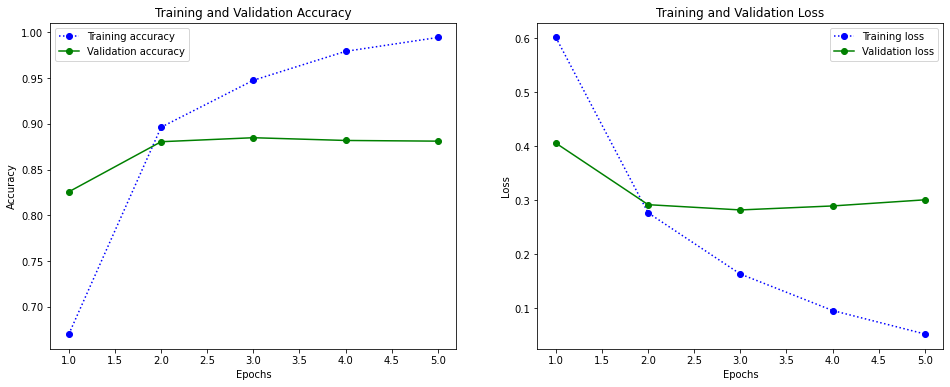

In [12]:
plot_validation_curve(history, ['accuracy','loss'])

In [13]:
y_pred_proba = ann.predict(X_test)

predictions_ann = (ann.predict(X_test) > 0.5).astype("int32")

classification_summary(y_test, predictions_ann, y_pred_proba)

Testing accuracy: 89.15%
________________________________________________________________________________
Confusion matrix:
 [[4522  490]
 [ 595 4393]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      5012
           1       0.90      0.88      0.89      4988

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



* The model with a simple ANN architecture is overfitting on the data. We can see that the test accuracy and loss plateaus after 2 epochs. The training accuracy is around 99 percent while the test accuracy is around 89 percent

* The precision and recall for both the classes are very good. They are around 0.88-0.90

In [14]:
# LSTM architecture with tanh activation

lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, activation='tanh', dropout=0.2,
               kernel_constraint=unit_norm(),
               recurrent_constraint=unit_norm(),
               bias_constraint=unit_norm()))
lstm.add(Dense(150, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 150)               19350     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 3,239,149
Trainable params: 3,239,149
No

In [15]:
epochs = 5
batches = 128
history = lstm.fit(X_train, y_train, epochs=epochs, batch_size=batches, validation_data = (X_valid,y_valid))

Epoch 1/5
250/250 [==============================] - 15s 41ms/step - loss: 0.6785 - accuracy: 0.5343 - val_loss: 0.6677 - val_accuracy: 0.5499
Epoch 2/5
250/250 [==============================] - 10s 38ms/step - loss: 0.6255 - accuracy: 0.5788 - val_loss: 0.6369 - val_accuracy: 0.5788
Epoch 3/5
250/250 [==============================] - 10s 38ms/step - loss: 0.6248 - accuracy: 0.5964 - val_loss: 0.6940 - val_accuracy: 0.5271
Epoch 4/5
250/250 [==============================] - 10s 38ms/step - loss: 0.5713 - accuracy: 0.6702 - val_loss: 0.5381 - val_accuracy: 0.7887
Epoch 5/5
250/250 [==============================] - 10s 40ms/step - loss: 0.6211 - accuracy: 0.6130 - val_loss: 0.6664 - val_accuracy: 0.5486


In [16]:
loss, acc = lstm.evaluate(X_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

313/313 [==============================] - 3s 10ms/step - loss: 0.6654 - accuracy: 0.5474
Test Loss: 0.6654 and Accuracy: 54.74%


<Figure size 432x288 with 0 Axes>

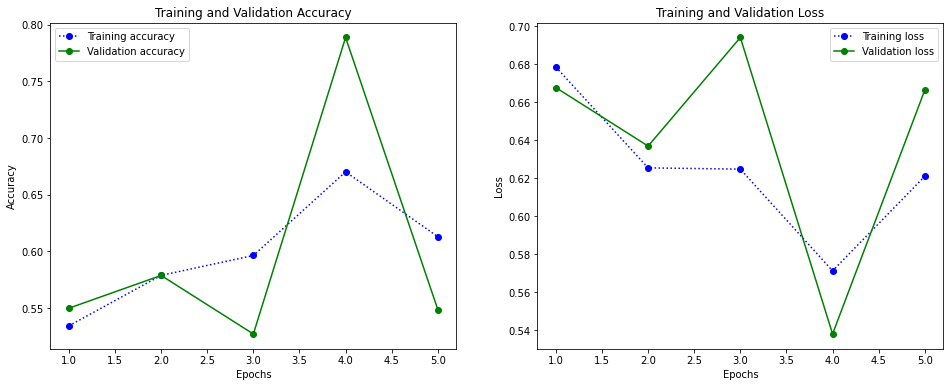

In [17]:
plot_validation_curve(history, ['accuracy','loss'])

In [18]:
y_pred_proba = lstm.predict(X_test)

predictions_lstm = (lstm.predict(X_test) > 0.5).astype("int32")

classification_summary(y_test, predictions_lstm, y_pred_proba)

Testing accuracy: 54.74%
________________________________________________________________________________
Confusion matrix:
 [[4538  474]
 [4052  936]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.91      0.67      5012
           1       0.66      0.19      0.29      4988

    accuracy                           0.55     10000
   macro avg       0.60      0.55      0.48     10000
weighted avg       0.60      0.55      0.48     10000



* The model with just the LSTM units with the tanh activation is underfitting. The training accuracy is only around 59 percent while the test accuracy is 54 percent.

* The validation loss and validation accuracy is fluctuating a lot. This model is not ideal to be used in production

* The precision and recall of both the classes are not good enough.

In [19]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu'))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 256)          2560000   
                                                                 
 dropout_2 (Dropout)         (None, 300, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 256)          327936    
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 64)           41024     
                                                      

In [20]:
# Fit the model
final = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 4, batch_size = 64, verbose = True)

Epoch 1/4
500/500 [==============================] - 22s 27ms/step - loss: 0.6622 - accuracy: 0.5811 - val_loss: 0.6286 - val_accuracy: 0.6055
Epoch 2/4
500/500 [==============================] - 13s 26ms/step - loss: 0.3033 - accuracy: 0.8740 - val_loss: 0.2598 - val_accuracy: 0.8951
Epoch 3/4
500/500 [==============================] - 13s 26ms/step - loss: 0.1837 - accuracy: 0.9306 - val_loss: 0.2764 - val_accuracy: 0.8880
Epoch 4/4
500/500 [==============================] - 13s 27ms/step - loss: 0.1302 - accuracy: 0.9538 - val_loss: 0.3069 - val_accuracy: 0.8873


In [21]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

313/313 [==============================] - 3s 8ms/step - loss: 0.2971 - accuracy: 0.8919
Test Loss: 0.2971 and Accuracy: 89.19%


<Figure size 432x288 with 0 Axes>

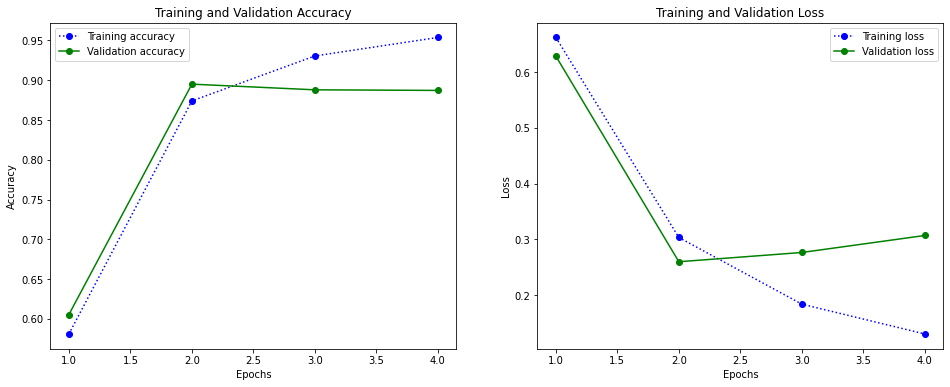

In [22]:
plot_validation_curve(final, ['accuracy','loss'])

In [23]:
y_pred_proba = model.predict(X_test)

predictions_model = (model.predict(X_test) > 0.5).astype("int32")

classification_summary(y_test, predictions_model, y_pred_proba)

Testing accuracy: 89.19%
________________________________________________________________________________
Confusion matrix:
 [[4316  696]
 [ 385 4603]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      5012
           1       0.87      0.92      0.89      4988

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



* LSTM with conv1d layer is neither overfitting nor underfitting. The trainig accuracy is around 95 percent and the testing accuracy is around 89 percent.

* The validation accuracy plateaus after 1.5 epochs and starts to decrease slightly. The validation loss decreases significantly.

* The preceision and recall of both the classes are very good.


**The model with LSTM units and Conv1d layer can be used in production as it produces more accuracte results**

In [24]:
# using the model to predict the test sample

decode_review(X_test[10], y_test[10])
print(f'Predicted sentiment: {predictions_model[10][0]}')

Review: bad or <UNK> man but he has a lousy relationship with his sons because he never really understood what was necessary in <UNK> a positive bond between his sons and himself he has always been too quick to criticize and <UNK> he always made it clear that he <UNK> his younger son over his older thus causing a wide emotional <UNK> between himself and andy as we get to know charles and andy the thought of andy <UNK> a plan to rob from his father becomes less unbelievable br br on a personal note i cannot believe how much charles <UNK> reminded me of my own father and how much andy and hank reminded me of my own brother and myself perhaps this may be one of the reasons that i enjoyed the film so much as this story of a distant critical father a more successful older brother and a less successful younger brother hit so close to home fortunately my brother and i never came to the state of committing a crime against my parents guess we were made of <UNK> and more moral stuff br br this c

**PART TWO**


• DOMAIN:  Social media analytics


• CONTEXT: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in
these requires the availability of contextual tweets.In this hands-on project, the goal is to
build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs

In [25]:
# importing the data

data = pd.read_json('/content/drive/MyDrive/NLP/Week_6_Assignment/Sarcasm_Headlines_Dataset.json', lines = True)
data.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [26]:
# checking for nulls in the datasets

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [27]:
# printing the types of each column

data.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

In [28]:
# dropping the irrelevant columns that won't be used for modelling

data.drop('article_link', axis = 1, inplace = True)

In [29]:
# getting lenght of each sentence
data['line_length'] = data['headline'].str.len()
print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length: {}'.format(data[data['line_length'] == data['line_length'].max()]['headline'].values[0]))

Minimum line length: 7
Maximum line length: 926
Line with maximum length: hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker to season omelet

In [30]:
# getting the number of words in each row
data['nb_words'] = data['headline'].apply(lambda x: len(x.split(' ')))
print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['headline'].values[0]))

Minimum number of words: 2
Maximum number of words: 151
Line with maximum number of words: hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker

In [31]:
# defining the a dictionary

appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

In [32]:
# using a function to replace the words with apostrophes

def remove_appos(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

In [33]:
# defining a function to lemmatizing the words 

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

In [34]:
# preprocessing the text

data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : remove_appos(x))
data['cleaned_headline'] = data['cleaned_headline'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: x.strip())
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lemmatize(x))

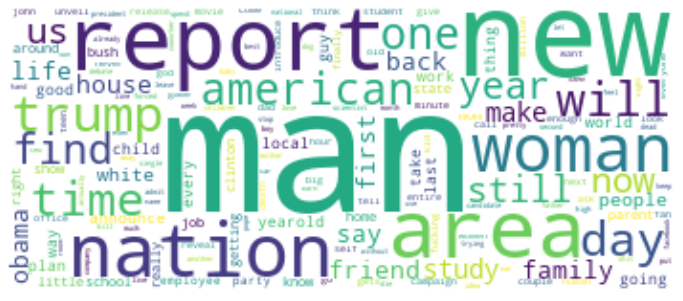

In [35]:
# displaying word cloud for sarcastic

sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
word_cloud_sarcastic = WordCloud(collocations = False, background_color = 'white',width = 350, height = 150,max_words = 300).generate(sarcastic_headlines)
# Display the generated Word Cloud
plt.figure(figsize = (12,6))
plt.imshow(word_cloud_sarcastic, interpolation='bilinear')
plt.axis("off")
plt.show()

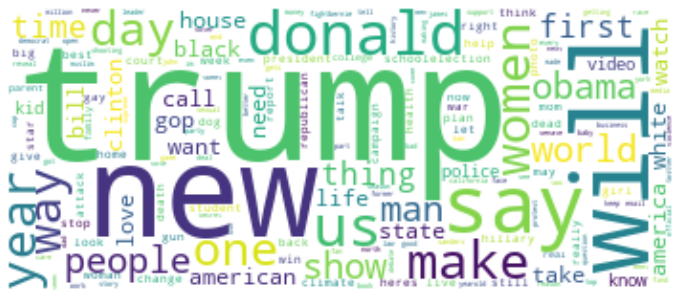

In [36]:
# displaying word cloud for non - sarcastic

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
word_cloud_non_sarcastic = WordCloud(collocations = False, background_color = 'white',width = 350, height = 150,max_words = 300).generate(non_sarcastic_headlines)
# Display the generated Word Cloud
plt.figure(figsize = (12,6))
plt.imshow(word_cloud_non_sarcastic, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
# defining the parameters

max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 50

In [38]:
# tokenizing each sentence in the dataset

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

# creating the features and labels
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  327 3039 6187 2051    2  649 1107]

Label of the first headline: 1


In [39]:
# getting the vocabulary size

w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'The vocabulary size is: {vocab_size}')

The vocabulary size is: 28778


In [40]:
# displaying the top 20 indices for words

print("Displaying the first 20 words and their indices",list(w2i.items())[:20])

Displaying the first 20 words and their indices [('to', 1), ('of', 2), ('the', 3), ('in', 4), ('for', 5), ('a', 6), ('on', 7), ('is', 8), ('and', 9), ('with', 10), ('not', 11), ('new', 12), ('trump', 13), ('man', 14), ('from', 15), ('at', 16), ('you', 17), ('it', 18), ('about', 19), ('by', 20)]


In [41]:
# using glove vector and their embeddings

EMBEDDING_FILE = '/content/drive/MyDrive/NLP/Week_6_Assignment/DataSet - glove.6B.50d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [42]:
# creating a weight matrix using glove vectors

num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [43]:
# splitting the data to train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

In [44]:
# defining our bidirectional lstm model

sar_model = Sequential()
sar_model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
sar_model.add(Bidirectional(LSTM(128, return_sequences = True)))
sar_model.add(GlobalMaxPool1D())
sar_model.add(Dropout(0.5, input_shape = (256,)))

sar_model.add(Dense(128, activation = 'relu'))
sar_model.add(Dropout(0.5, input_shape = (128,)))

sar_model.add(Dense(64, activation = 'relu'))
sar_model.add(Dropout(0.5, input_shape = (64,)))

sar_model.add(Dense(32,activation = 'relu'))
sar_model.add(Dropout(0.5, input_shape = (32,)))

sar_model.add(Dense(16,activation = 'relu'))
sar_model.add(Dropout(0.5, input_shape = (16,)))

sar_model.add(Dense(1, activation = 'sigmoid'))

sar_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(sar_model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 151, 50)           500050    
                                                                 
 bidirectional (Bidirectiona  (None, 151, 256)         183296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [45]:
# fitting the model on the training set

batch_size = 32
epochs = 20
h = sar_model.fit(X_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size)

Epoch 1/20
573/573 [==============================] - 19s 26ms/step - loss: 0.6957 - accuracy: 0.5145 - val_loss: 0.6920 - val_accuracy: 0.5174
Epoch 2/20
573/573 [==============================] - 14s 24ms/step - loss: 0.6721 - accuracy: 0.5789 - val_loss: 0.5991 - val_accuracy: 0.6986
Epoch 3/20
573/573 [==============================] - 14s 24ms/step - loss: 0.5651 - accuracy: 0.7273 - val_loss: 0.4717 - val_accuracy: 0.7967
Epoch 4/20
573/573 [==============================] - 14s 24ms/step - loss: 0.4964 - accuracy: 0.7810 - val_loss: 0.4245 - val_accuracy: 0.8059
Epoch 5/20
573/573 [==============================] - 14s 24ms/step - loss: 0.4591 - accuracy: 0.8060 - val_loss: 0.4027 - val_accuracy: 0.8168
Epoch 6/20
573/573 [==============================] - 14s 24ms/step - loss: 0.4213 - accuracy: 0.8203 - val_loss: 0.3974 - val_accuracy: 0.8176
Epoch 7/20
573/573 [==============================] - 14s 24ms/step - loss: 0.4020 - accuracy: 0.8366 - val_loss: 0.3841 - val_accuracy:

In [46]:
y_pred_proba_sar_model = sar_model.predict(X_test)

predictions_sar_model = (sar_model.predict(X_test) > 0.5).astype("int32")

classification_summary(y_test, predictions_sar_model, y_pred_proba_sar_model)

Testing accuracy: 83.65%
________________________________________________________________________________
Confusion matrix:
 [[2688  289]
 [ 647 2100]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      2977
           1       0.88      0.76      0.82      2747

    accuracy                           0.84      5724
   macro avg       0.84      0.83      0.83      5724
weighted avg       0.84      0.84      0.84      5724



* The model has training accuracy of 92 percent and validation accuracy of 83 percent. This model is not overfitting. 

* The precision and recall is good for both the classes.

* This model will perform good on production data.